# 🚦 Checkpoint 1: Understand the Dataset

In [13]:
import pandas as pd

In [14]:
#Load Dataset
df = pd.read_csv("netflix_titles.csv")

In [15]:
#Data Shape
print("Data Shape:", df.shape)

#Data Columns
print("Data columns:" , df.columns)

#View first 5 rows
print("Data")
#print(df.head())

#Data Types
print(df.dtypes)

#Checking missing Data
print(df.isna().sum())

Data Shape: (8807, 12)
Data columns: Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')
Data
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object
show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


# 🚦 Checkpoint 2: Data Cleaning

In [16]:
# categorical column where the number of unique values = number of rows
for col in df.select_dtypes(include='object').columns:
    if df[col].nunique() == len(df):
        print(f"'{col}' — high cardinality")

# Remove show_id column
df.drop(columns=["show_id"], inplace=True)
# Remove description (not needed)
df.drop(columns=["description"], inplace=True)

# columns with missing
cols_with_missing = [col for col in df.columns if df[col].isnull().sum() > 0]
print("Columns with missing Values:", cols_with_missing)
print("Columns with missing Values Types:", df[cols_with_missing].dtypes) # all are categorical data only date want to be converted

# Dealing with some missing values
for col in cols_with_missing:
    df[col + "_missing"] = df[col].isnull()
    df.fillna({col : df[col].mode()[0]}, inplace= True)

#Convert date_added type to date
# Strip extra spaces from date strings (sometimes there are leading/trailing spaces)
df['date_added'] = df['date_added'].str.strip()

# Convert to datetime using correct format: 'September 25, 2021'
df['date_added'] = pd.to_datetime(df['date_added'], format='%B %d, %Y', errors='coerce')

print("Missing/invalid dates:", df['date_added'].isna().sum())

#Drop Duplicates
df.drop_duplicates(inplace= True)
df.reset_index(drop=True, inplace=True)




'show_id' — high cardinality
'title' — high cardinality
Columns with missing Values: ['director', 'cast', 'country', 'date_added', 'rating', 'duration']
Columns with missing Values Types: director      object
cast          object
country       object
date_added    object
rating        object
duration      object
dtype: object
Missing/invalid dates: 0


# 🚦 Checkpoint 3: EDA (Exploratory Data Analysis)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")  # Clean style
plt.rcParams['figure.figsize'] = (10, 6)

### ✅ Step 1: Content Type Distribution (Movie vs TV Show)

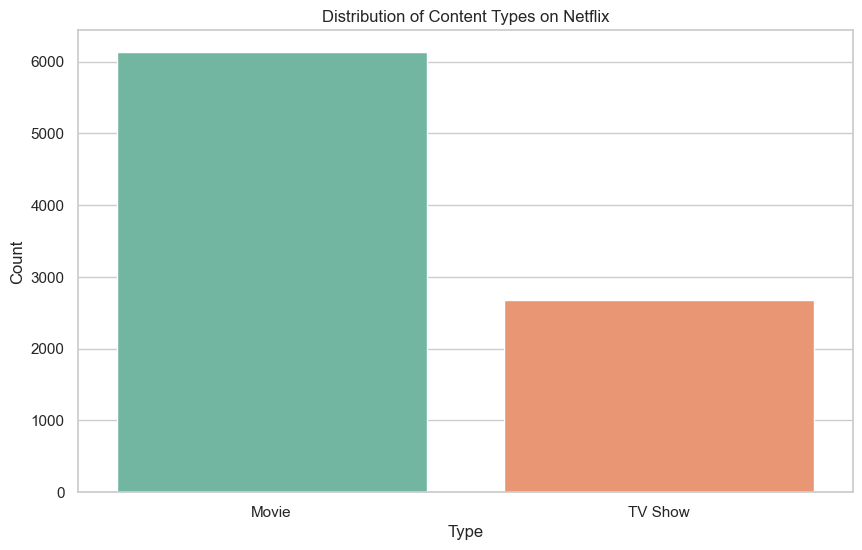

In [18]:
sns.countplot(x='type', data=df, palette='Set2')
plt.title('Distribution of Content Types on Netflix')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

### ✅ Step 2: Content Added by Year

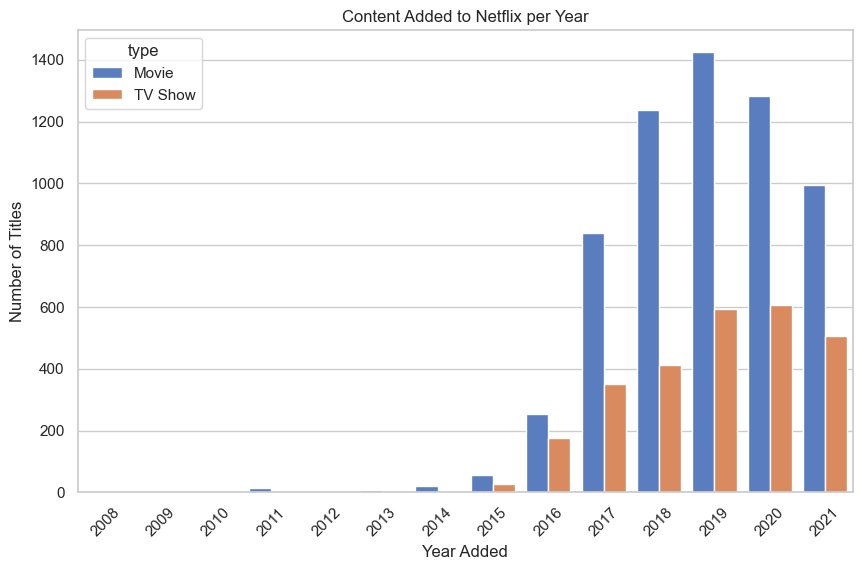

In [19]:
df['year_added'] = df['date_added'].dt.year  # Create a year column

sns.countplot(data=df , x = 'year_added' , hue='type' , palette="muted")
plt.title('Content Added to Netflix per Year')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)
plt.show()

### ✅ Step 3: Top 10 Countries by Content Count

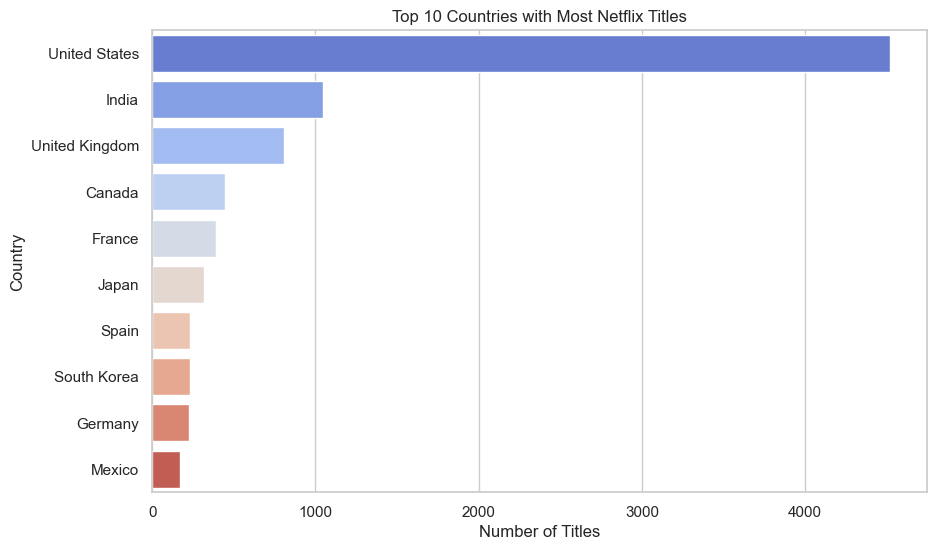

In [20]:
country_data = df['country'].dropna().str.split(',').explode().str.strip()
top_countries = country_data.value_counts().head(10)

sns.barplot(y=top_countries.index, x=top_countries.values, palette='coolwarm')
plt.title('Top 10 Countries with Most Netflix Titles')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.show()

### ✅ Step 4: Top 10 Genres (from listed_in column)

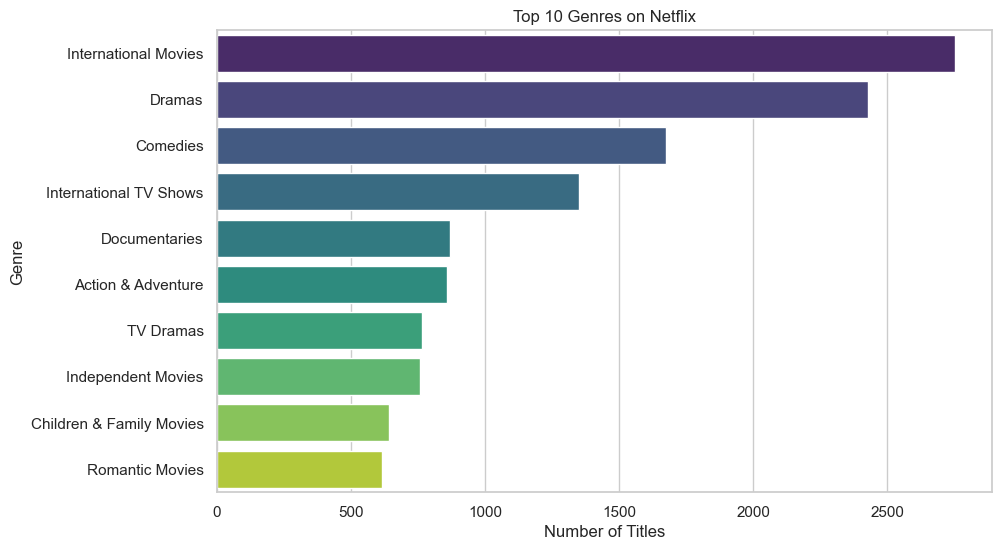

In [21]:
genre_data = df.listed_in.str.split(',').explode().str.strip()
top_genres = genre_data.value_counts().head(10)
sns.barplot(y = top_genres.index , x = top_genres.values , palette="viridis")
plt.title('Top 10 Genres on Netflix')
plt.xlabel('Number of Titles')
plt.ylabel('Genre')
plt.show()

# 🚦 Checkpoint 4: ML-Based Recommendation System

In [22]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # Loads in seconds and works well

In [24]:
# Create a new text column for embeddings
df['text'] = df['title'] + ' ' + df['listed_in'] + ' ' + df['type']

In [25]:
df[['title', 'text']].head()

,title,text
0,Dick Johnson Is Dead,Dick Johnson Is Dead Documentaries Movie
1,Blood & Water,"Blood & Water International TV Shows, TV Drama..."
2,Ganglands,"Ganglands Crime TV Shows, International TV Sho..."
3,Jailbirds New Orleans,"Jailbirds New Orleans Docuseries, Reality TV T..."
4,Kota Factory,"Kota Factory International TV Shows, Romantic ..."


In [26]:
embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 276/276 [01:19<00:00,  3.45it/s]


In [27]:
df['embedding'] = list(np.array(embeddings))

In [28]:

def recommend(title, df, top_n=5):
    # Check if title exists
    if title not in df['title'].values:
        print(f"Sorry, '{title}' not found in dataset.")
        return []

    # Get the embedding for the given title
    query_vec = df.loc[df['title'] == title, 'embedding'].values[0]

    # Compute cosine similarity between query_vec and all embeddings
    similarities = cosine_similarity([query_vec], list(df['embedding']))[0]

    similar_indices = similarities.argsort()[::-1][1:top_n+1]

    # Return the top_n similar titles with similarity scores
    results = [(df.iloc[i]['title'], similarities[i]) for i in similar_indices]
    return results

In [29]:
recommendations = recommend("Narcos", df, top_n=5)
for title, score in recommendations:
    print(f"{title} - Similarity: {score:.3f}")

Narcos: Mexico - Similarity: 0.903
Dealer - Similarity: 0.820
Crime Time - Similarity: 0.803
Narcoworld: Dope Stories - Similarity: 0.801
Taken - Similarity: 0.790


In [32]:
df.to_csv('cleaned_netflix_data.csv')